In [ ]:
import cv2
import numpy as np
import tkinter as tk
from tkinter import Toplevel, Scale, Radiobutton, IntVar, Button
from PIL import Image, ImageTk
from gravitational_lensing_effect import schwarzschild_lens_effect, kerr_lens_effect

class ParameterWindow:
    def __init__(self, master, app):
        self.master = master
        self.app = app
        self.master.title("パラメーター設定")

        self.scale_rs = self.create_scale_with_reset("シュバルツシルト半径", 10, 100, 50, self.reset_rs)
        self.scale_x = self.create_scale_with_reset("レンズ天体のX位置", -app.width//2, app.width//2, 0, self.reset_x)
        self.scale_y = self.create_scale_with_reset("レンズ天体のY位置", -app.height//2, app.height//2, 0, self.reset_y)
        self.scale_a = self.create_scale_with_reset("Kerrパラメータ a", 0, 1, 0.5, self.reset_a)
        self.scale_window_size = self.create_scale_with_reset("ウィンドウサイズ", 400, 1600, 800, self.reset_window_size, resolution=100)

        self.bh_type = IntVar()
        self.bh_type.set(1)  # デフォルトはシュバルツシルトブラックホール

        Radiobutton(master, text="シュバルツシルトブラックホール", variable=self.bh_type, value=1).pack(anchor=tk.W)
        Radiobutton(master, text="Kerrブラックホール", variable=self.bh_type, value=2).pack(anchor=tk.W)

        self.update_button = tk.Button(master, text="更新", command=self.update_parameters)
        self.update_button.pack()

    def create_scale_with_reset(self, label, from_, to_, initial, reset_command, resolution=1):
        frame = tk.Frame(self.master)
        frame.pack(fill=tk.X)

        scale = Scale(frame, from_=from_, to_=to_, orient=tk.HORIZONTAL, label=label, resolution=resolution)
        scale.set(initial)
        scale.pack(side=tk.LEFT, expand=True, fill=tk.X)

        button = Button(frame, text="リセット", command=reset_command)
        button.pack(side=tk.RIGHT)

        return scale

    def reset_rs(self):
        self.scale_rs.set(50)

    def reset_x(self):
        self.scale_x.set(0)

    def reset_y(self):
        self.scale_y.set(0)

    def reset_a(self):
        self.scale_a.set(0.5)

    def reset_window_size(self):
        self.scale_window_size.set(800)

    def update_parameters(self):
        self.app.Rs = self.scale_rs.get()
        self.app.lens_x = self.app.width // 2 + self.scale_x.get()
        self.app.lens_y = self.app.height // 2 + self.scale_y.get()
        self.app.a = self.scale_a.get()
        self.app.window_size = self.scale_window_size.get()
        self.app.bh_type = self.bh_type.get()

class ImageWindow:
    def __init__(self, master, app):
        self.master = master
        self.app = app
        self.master.title("画像表示")
        self.canvas = tk.Canvas(master, width=app.window_size * 2, height=app.window_size)
        self.canvas.pack()
        self.image_on_canvas = None
        self.image_refs = []  # 参照を保持するリスト
        self.update()

    def update(self):
        ret, frame = self.app.cap.read()
        if ret:
            if self.app.bh_type == 1:
                lensed_frame = schwarzschild_lens_effect(frame, Rs=self.app.Rs, center=(self.app.lens_x, self.app.lens_y))
            else:
                lensed_frame = kerr_lens_effect(frame, Rs=self.app.Rs, a=self.app.a, center=(self.app.lens_x, self.app.lens_y))

            combined_frame = np.hstack((frame, lensed_frame))

            # 画像のサイズをウィンドウサイズに合わせてリサイズ
            combined_frame = cv2.resize(combined_frame, (self.app.window_size * 2, self.app.window_size))
            combined_frame = cv2.cvtColor(combined_frame, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(combined_frame)
            imgtk = ImageTk.PhotoImage(image=image)
            self.image_refs.append(imgtk)  # 参照をリストに追加

            if self.image_on_canvas is None:
                self.image_on_canvas = self.canvas.create_image(0, 0, anchor=tk.NW, image=imgtk)
            else:
                self.canvas.itemconfig(self.image_on_canvas, image=imgtk)

        self.master.after(10, self.update)

class App:
    def __init__(self, root):
        self.root = root
        self.cap = cv2.VideoCapture(0)
        if not self.cap.isOpened():
            print("カメラが見つかりません")
            exit()

        self.width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        self.Rs = 50
        self.lens_x = self.width // 2
        self.lens_y = self.height // 2
        self.a = 0.5
        self.window_size = 800  # 初期ウィンドウサイズ
        self.bh_type = 1

        param_window = Toplevel(self.root)
        self.param_win = ParameterWindow(param_window, self)

        image_window = Toplevel(self.root)
        self.image_win = ImageWindow(image_window, self)

    def __del__(self):
        if self.cap.isOpened():
            self.cap.release()

root = tk.Tk()
app = App(root)
root.mainloop()


In [5]:
import cv2

def test_camera(device_index=0):
    cap = cv2.VideoCapture(device_index)
    if not cap.isOpened():
        print(f"カメラデバイス {device_index} を開くことができません。")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            print("フレームを取得できません。")
            break

        cv2.imshow("Camera Test", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    test_camera(0)  # 必要に応じてデバイスインデックスを変更


フレームを取得できません。


In [7]:
import numpy as np
import cv2

# パラメータの設定
G = 1  # 重力定数 (適宜調整)
mass = 1.0e+5  # ブラックホールの質量 (適宜調整)
scale = 1  # スケール (適宜調整)

def schwarzschild_transform(frame, G, mass, scale):
    height, width, _ = frame.shape
    new_frame = np.zeros_like(frame)

    # 光の経路を計算して画像を変形
    for y in range(height):
        for x in range(width):
            x_normalized = (x - width / 2) * scale
            y_normalized = (y - height / 2) * scale
            r = np.sqrt(x_normalized**2 + y_normalized**2)
            
            if r != 0:
                theta = np.arctan2(y_normalized, x_normalized)
                r_new = r - (2 * G * mass / r**2)  # シュバルツシルト半径を考慮した変形
                x_new = int(r_new * np.cos(theta) / scale + width / 2)
                y_new = int(r_new * np.sin(theta) / scale + height / 2)

                if 0 <= x_new < width and 0 <= y_new < height:
                    new_frame[y, x] = frame[y_new, x_new]
                else:
                    new_frame[y, x] = (0, 0, 0)
            else:
                new_frame[y, x] = frame[y, x]

    return new_frame

# カメラから画像を取得し、変形を適用
def main():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("カメラを開けませんでした。")
        return
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("フレームを取得できませんでした。")
            break

        transformed_frame = schwarzschild_transform(frame, G, mass, scale)

        cv2.imshow('Schwarzschild Transform', transformed_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()


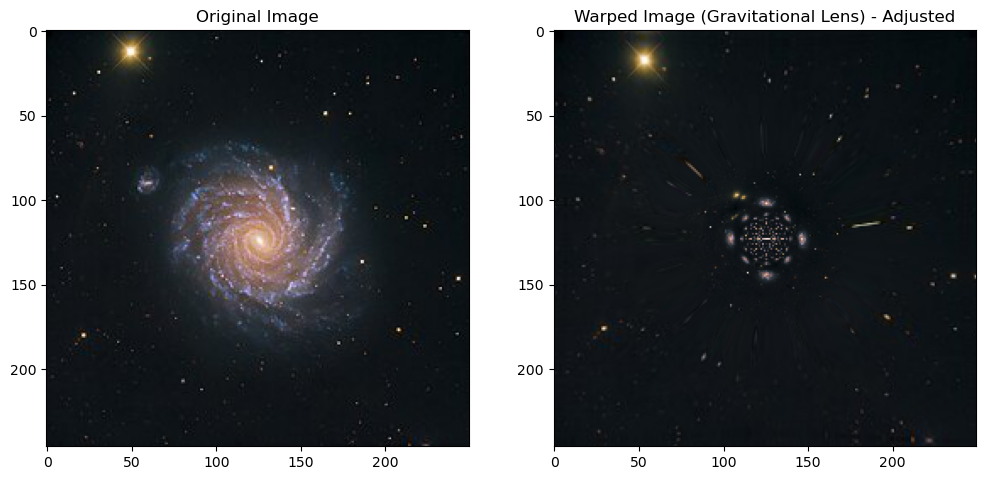

In [5]:
def gravitational_lens_simulation_adjusted(image, lens_mass, lens_position, lens_scale):
    # 画像の寸法を取得
    height, width = image.shape[:2]  # 2次元の形状を取得

    # ピクセル座標のグリッドを作成
    y, x = np.mgrid[0:height, 0:width]
    x = x - lens_position[0]
    y = y - lens_position[1]

    # 距離を計算
    r_squared = x**2 + y**2
    r_squared = np.maximum(r_squared, 1e-6)  # ゼロ除算を避けるために小さな値を追加

    # 点質量レンズの変位角度を計算
    deflection_angle = lens_scale * lens_mass / r_squared

    # 新しいピクセル位置を計算
    x_new = x + deflection_angle * x / np.sqrt(r_squared)
    y_new = y + deflection_angle * y / np.sqrt(r_squared)

    x_new += lens_position[0]
    y_new += lens_position[1]

    # 新しい座標に基づいて画像をサンプリング
    coordinates = np.array([y_new, x_new])

    # 画像がカラーの場合（3次元の場合）、各チャンネルを個別に変換
    if image.ndim == 3:
        warped_image = np.zeros_like(image)
        for i in range(image.shape[2]):
            warped_image[..., i] = map_coordinates(image[..., i], coordinates, order=1, mode='reflect')
    else:
        warped_image = map_coordinates(image, coordinates, order=1, mode='reflect')

    return warped_image

# レンズのパラメータを設定
lens_mass = 10
lens_position = [image.shape[1] // 2, image.shape[0] // 2]  # 画像中心
lens_scale = 10000  # レンズのスケールを設定（値を調整可能）

# 重力レンズシミュレーションを実行
warped_image_adjusted = gravitational_lens_simulation_adjusted(image, lens_mass, lens_position, lens_scale)

# 結果をプロット
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title('Warped Image (Gravitational Lens) - Adjusted')
plt.imshow(warped_image_adjusted)

plt.show()


C:\Users\yuki\AppData\Local\Temp\ipykernel_22404\834533002.py:47: RuntimeWarning: divide by zero encountered in divide
  beta = theta - (R_E**2 / theta)  # 修正された角度 [arcsec]
C:\Users\yuki\AppData\Local\Temp\ipykernel_22404\834533002.py:50: RuntimeWarning: invalid value encountered in multiply
  x_new = image_pixel_Center[0] + (pixel_coords[:, 0] - image_pixel_Center[0]) * factor
C:\Users\yuki\AppData\Local\Temp\ipykernel_22404\834533002.py:51: RuntimeWarning: invalid value encountered in multiply
  y_new = image_pixel_Center[1] + (pixel_coords[:, 1] - image_pixel_Center[1]) * factor
C:\Users\yuki\AppData\Local\Temp\ipykernel_22404\834533002.py:53: RuntimeWarning: invalid value encountered in cast
  return np.stack((x_new, y_new), axis=-1).astype(int)


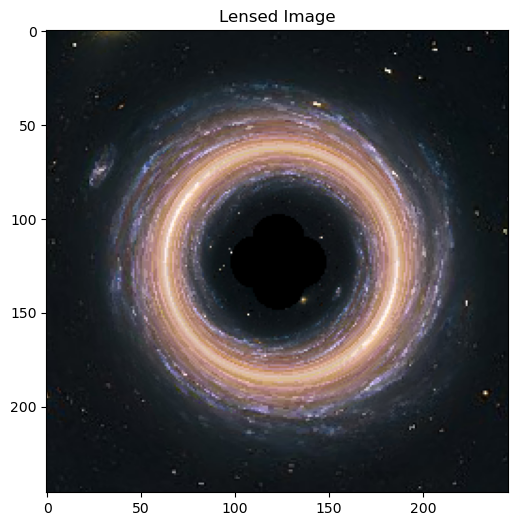

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import math
import astropy.constants as c
import astropy.units as u

# 定数の定義
radtoarcsec = 206265
arcsectorad = 1/radtoarcsec

# 画像の読み込みと前処理
image_file = "NGC_1232.jpg"  # ここにパスを指定
image_data_unshapped = img.imread(image_file)
image_min_side_inxlength = np.min(image_data_unshapped.shape[:2])
image_data = image_data_unshapped[:image_min_side_inxlength, :image_min_side_inxlength]
source_data = np.empty(image_data.shape)

# 物理パラメータの設定
D_L = 500 * u.pc  # ブラックホールまでの距離
D_S = 3000 * u.pc  # ソースまでの距離
D_LS = np.abs(D_S - D_L)  # ブラックホールからソースまでの距離
G = c.G
M = 10**11 * u.Msun  # ブラックホールの質量
C = c.c.to(u.m/u.s)

# アインシュタイン半径の計算
R_E = np.sqrt((4 * G * M * D_LS) / ((C**2) * D_L * D_S)).decompose().value * radtoarcsec  # アインシュタイン半径 [arcsec]

# Schwarzschild半径の計算
schwarz_radius = (((2 * c.G * M / (c.c**2)))).to(u.pc)

# 画像サイズの計算
image_Ang_Size = 2.0 * R_E
image_Mat_Len = image_min_side_inxlength
image_pixel_Center = np.array([image_Mat_Len / 2, image_Mat_Len / 2])
image_Length = 2 * np.tan(image_Ang_Size * arcsectorad) * D_S.to_value(u.pc)  # 実際のサイズ [pc]
pixel_Size = image_Length / image_Mat_Len

def invlensed_pixel_vectorized(pixel_coords):
    """ベクトル化された重力レンズ効果"""
    dx = (pixel_coords[:, 0] - image_pixel_Center[0]) * pixel_Size / D_S.to_value(u.pc)
    dy = (pixel_coords[:, 1] - image_pixel_Center[1]) * pixel_Size / D_S.to_value(u.pc)
    r = np.sqrt(dx**2 + dy**2)
    
    theta = np.arctan(r) * radtoarcsec  # 角度 [arcsec]
    beta = theta - (R_E**2 / theta)  # 修正された角度 [arcsec]
    
    factor = beta / theta
    x_new = image_pixel_Center[0] + (pixel_coords[:, 0] - image_pixel_Center[0]) * factor
    y_new = image_pixel_Center[1] + (pixel_coords[:, 1] - image_pixel_Center[1]) * factor
    
    return np.stack((x_new, y_new), axis=-1).astype(int)

def generate_lensed_image_vectorized():
    pixel_coords = np.indices((image_Mat_Len, image_Mat_Len)).reshape(2, -1).T
    lensed_coords = invlensed_pixel_vectorized(pixel_coords)
    
    valid_mask = (
        (lensed_coords[:, 0] >= 0) & (lensed_coords[:, 0] < image_Mat_Len) &
        (lensed_coords[:, 1] >= 0) & (lensed_coords[:, 1] < image_Mat_Len)
    )
    
    lensed_image = np.zeros_like(image_data)
    lensed_image[pixel_coords[valid_mask, 0], pixel_coords[valid_mask, 1]] = \
        image_data[lensed_coords[valid_mask, 0], lensed_coords[valid_mask, 1]]
    
    return lensed_image

# 結果をプロット
def plot_lensed_image(lensed_image):
    plt.figure(figsize=(12, 6))
    plt.imshow(lensed_image)
    plt.title('Lensed Image')
    plt.show()

# レンズ効果のある画像を生成して表示
lensed_image = generate_lensed_image_vectorized()
plot_lensed_image(lensed_image)


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import astropy.constants as c
import astropy.units as u

# 定数の定義
radtoarcsec = 206265
arcsectorad = 1/radtoarcsec

# 物理パラメータの設定
D_L = 500 * u.pc  # ブラックホールまでの距離
D_S = 3000 * u.pc  # ソースまでの距離
D_LS = np.abs(D_S - D_L)  # ブラックホールからソースまでの距離
G = c.G
M = 10**11 * u.Msun  # ブラックホールの質量
C = c.c.to(u.m/u.s)

# アインシュタイン半径の計算
R_E = np.sqrt((4 * G * M * D_LS) / ((C**2) * D_L * D_S)).decompose().value * radtoarcsec  # アインシュタイン半径 [arcsec]

# Schwarzschild半径の計算
schwarz_radius = (((2 * c.G * M / (c.c**2)))).to(u.pc)

def invlensed_pixel_vectorized(image_data, pixel_coords, image_pixel_Center, pixel_Size):
    """ベクトル化された重力レンズ効果"""
    dx = (pixel_coords[:, 0] - image_pixel_Center[0]) * pixel_Size / D_S.to_value(u.pc)
    dy = (pixel_coords[:, 1] - image_pixel_Center[1]) * pixel_Size / D_S.to_value(u.pc)
    r = np.sqrt(dx**2 + dy**2)
    
    theta = np.arctan(r) * radtoarcsec  # 角度 [arcsec]
    beta = theta - (R_E**2 / theta)  # 修正された角度 [arcsec]
    
    factor = beta / theta
    x_new = image_pixel_Center[0] + (pixel_coords[:, 0] - image_pixel_Center[0]) * factor
    y_new = image_pixel_Center[1] + (pixel_coords[:, 1] - image_pixel_Center[1]) * factor
    
    return np.stack((x_new, y_new), axis=-1).astype(int)

def generate_lensed_image_vectorized(image_data):
    image_Mat_Len = image_data.shape[0]
    image_pixel_Center = np.array([image_Mat_Len / 2, image_Mat_Len / 2])
    image_Ang_Size = 2.0 * R_E
    image_Length = 2 * np.tan(image_Ang_Size * arcsectorad) * D_S.to_value(u.pc)  # 実際のサイズ [pc]
    pixel_Size = image_Length / image_Mat_Len

    pixel_coords = np.indices((image_Mat_Len, image_Mat_Len)).reshape(2, -1).T
    lensed_coords = invlensed_pixel_vectorized(image_data, pixel_coords, image_pixel_Center, pixel_Size)
    
    valid_mask = (
        (lensed_coords[:, 0] >= 0) & (lensed_coords[:, 0] < image_Mat_Len) &
        (lensed_coords[:, 1] >= 0) & (lensed_coords[:, 1] < image_Mat_Len)
    )
    
    lensed_image = np.zeros_like(image_data)
    lensed_image[pixel_coords[valid_mask, 0], pixel_coords[valid_mask, 1]] = \
        image_data[lensed_coords[valid_mask, 0], lensed_coords[valid_mask, 1]]
    
    return lensed_image

# カメラから画像を取得してリアルタイムで表示する
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # フレームの最小サイドを基に画像を正方形にクロップ
    image_min_side_inxlength = min(frame.shape[:2])
    image_data = frame[:image_min_side_inxlength, :image_min_side_inxlength]

    # 重力レンズ効果を適用
    lensed_image = generate_lensed_image_vectorized(image_data)
    
    # OpenCVを使用して結果を表示
    cv2.imshow('Gravitational Lensed Image', lensed_image)
    
    # 'q'キーが押されたら終了
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 終了処理
cap.release()
cv2.destroyAllWindows()


C:\Users\yuki\AppData\Local\Temp\ipykernel_22404\102013836.py:33: RuntimeWarning: divide by zero encountered in divide
  beta = theta - (R_E**2 / theta)  # 修正された角度 [arcsec]
C:\Users\yuki\AppData\Local\Temp\ipykernel_22404\102013836.py:36: RuntimeWarning: invalid value encountered in multiply
  x_new = image_pixel_Center[0] + (pixel_coords[:, 0] - image_pixel_Center[0]) * factor
C:\Users\yuki\AppData\Local\Temp\ipykernel_22404\102013836.py:37: RuntimeWarning: invalid value encountered in multiply
  y_new = image_pixel_Center[1] + (pixel_coords[:, 1] - image_pixel_Center[1]) * factor
C:\Users\yuki\AppData\Local\Temp\ipykernel_22404\102013836.py:39: RuntimeWarning: invalid value encountered in cast
  return np.stack((x_new, y_new), axis=-1).astype(int)


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import astropy.constants as c
import astropy.units as u

# 定数の定義
radtoarcsec = 206265
arcsectorad = 1/radtoarcsec

# 物理パラメータの設定
D_L = 700 * u.pc  # ブラックホールまでの距離
D_S = 3000 * u.pc  # ソースまでの距離
D_LS = np.abs(D_S - D_L)  # ブラックホールからソースまでの距離
G = c.G
M = 10**12 * u.Msun  # ブラックホールの質量
C = c.c.to(u.m/u.s)

# アインシュタイン半径の計算
R_E = np.sqrt((4 * G * M * D_LS) / ((C**2) * D_L * D_S)).decompose().value * radtoarcsec  # アインシュタイン半径 [arcsec]

def invlensed_pixel_vectorized(image_data, pixel_coords, image_pixel_Center, pixel_Size, lens_radius):
    """ベクトル化された重力レンズ効果"""
    dx = (pixel_coords[:, 0] - image_pixel_Center[0]) * pixel_Size / D_S.to_value(u.pc)
    dy = (pixel_coords[:, 1] - image_pixel_Center[1]) * pixel_Size / D_S.to_value(u.pc)
    r = np.sqrt(dx**2 + dy**2)
    
    theta = np.arctan(r) * radtoarcsec  # 角度 [arcsec]
    beta = theta - (R_E**2 / theta)  # 修正された角度 [arcsec]
    
    factor = beta / theta
    x_new = image_pixel_Center[0] + (pixel_coords[:, 0] - image_pixel_Center[0]) * factor
    y_new = image_pixel_Center[1] + (pixel_coords[:, 1] - image_pixel_Center[1]) * factor
    
    lensed_coords = np.stack((x_new, y_new), axis=-1).astype(int)
    
    # レンズの半径内のみ効果を適用
    distance_from_center = np.sqrt((pixel_coords[:, 0] - image_pixel_Center[0])**2 +
                                   (pixel_coords[:, 1] - image_pixel_Center[1])**2)
    
    mask = distance_from_center <= lens_radius
    
    # レンズの外側は元の座標を使用
    lensed_coords[~mask] = pixel_coords[~mask]
    
    return lensed_coords, mask

def generate_lensed_image_vectorized(image_data):
    image_Mat_Len = image_data.shape[0]
    image_pixel_Center = np.array([image_Mat_Len / 2, image_Mat_Len / 2])
    image_Ang_Size = 2.0 * R_E
    image_Length = 2 * np.tan(image_Ang_Size * arcsectorad) * D_S.to_value(u.pc)  # 実際のサイズ [pc]
    pixel_Size = image_Length / image_Mat_Len
    
    lens_radius = image_Mat_Len / 4  # レンズの半径を設定 (画像サイズの1/4)
    
    pixel_coords = np.indices((image_Mat_Len, image_Mat_Len)).reshape(2, -1).T
    lensed_coords, mask = invlensed_pixel_vectorized(image_data, pixel_coords, image_pixel_Center, pixel_Size, lens_radius)
    
    lensed_image = np.zeros_like(image_data)
    
    # レンズの内側の領域に対して重力レンズ効果を適用
    valid_mask = (
        (lensed_coords[:, 0] >= 0) & (lensed_coords[:, 0] < image_Mat_Len) &
        (lensed_coords[:, 1] >= 0) & (lensed_coords[:, 1] < image_Mat_Len) & mask
    )
    
    lensed_image[pixel_coords[valid_mask, 0], pixel_coords[valid_mask, 1]] = \
        image_data[lensed_coords[valid_mask, 0], lensed_coords[valid_mask, 1]]
    
    # レンズの外側の領域は元の画像を使用
    lensed_image[~mask.reshape(image_Mat_Len, image_Mat_Len)] = \
        image_data[~mask.reshape(image_Mat_Len, image_Mat_Len)]
    
    return lensed_image

# カメラから画像を取得してリアルタイムで表示する
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # フレームの最小サイドを基に画像を正方形にクロップ
    image_min_side_inxlength = min(frame.shape[:2])
    image_data = frame[:image_min_side_inxlength, :image_min_side_inxlength]

    # 重力レンズ効果を適用
    lensed_image = generate_lensed_image_vectorized(image_data)
    
    # OpenCVを使用して結果を表示
    cv2.imshow('Gravitational Lensed Image', lensed_image)
    
    # 'q'キーが押されたら終了
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 終了処理
cap.release()
cv2.destroyAllWindows()


C:\Users\yuki\AppData\Local\Temp\ipykernel_22880\2770311372.py:30: RuntimeWarning: divide by zero encountered in divide
  beta = theta - (R_E**2 / theta)  # 修正された角度 [arcsec]
C:\Users\yuki\AppData\Local\Temp\ipykernel_22880\2770311372.py:33: RuntimeWarning: invalid value encountered in multiply
  x_new = image_pixel_Center[0] + (pixel_coords[:, 0] - image_pixel_Center[0]) * factor
C:\Users\yuki\AppData\Local\Temp\ipykernel_22880\2770311372.py:34: RuntimeWarning: invalid value encountered in multiply
  y_new = image_pixel_Center[1] + (pixel_coords[:, 1] - image_pixel_Center[1]) * factor
C:\Users\yuki\AppData\Local\Temp\ipykernel_22880\2770311372.py:36: RuntimeWarning: invalid value encountered in cast
  lensed_coords = np.stack((x_new, y_new), axis=-1).astype(int)


In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.patches as ptch
from matplotlib.widgets import Slider
from matplotlib.widgets import Button
import astropy.constants as c
import astropy.units as u
import random
import numpy as np
import math
from multiprocessing import Pool
import os

radtoarcsec = 206265
arcsectorad = 1/radtoarcsec



#Open the image file as a matrix of rgb values
# image_file = "./test_images/eso1738e.jpg" #relative path to image file
image_file = "NGC_1232.jpg"
image_data_unshapped = img.imread(image_file) #import image file as a matrix. Each component of the NxM matrix is a length 3 array containing the RGB values of the pixel.
image_min_side_inxlength = np.min(image_data_unshapped.shape[:2]) #find the minimum length of the image matrix. I.E. for an NxM matrix, which is smaller the 'N' or the 'M'?
image_data = image_data_unshapped[:image_min_side_inxlength,:image_min_side_inxlength] #crop the matrix using the minimum side length so that it is square. I.E. if 'N' is smaller, then reshape to an NxN matrix.
source_data = np.empty(image_data.shape) #Create the target matrix that will be populated by the lensed pixels of the input matrix

#setup the physical system
D_L = 500*u.pc # Distance to black hole in parsecs
D_S = 3000*u.pc # Distance to source object in parsecs. This assumes the stars in the image are distributed planarly and they are much further away from the hole than they are from each other. This assumption makes the math much easier
D_LS = np.abs(D_S-D_L) #parsecs. distance from source to hole
G = c.G #gravitational constant
M = 10**11*u.Msun #solar masses. Mass of lensing hole
C = c.c.to(u.m/u.s) #m/s. speed of light
R_E = np.sqrt((4*G*M*D_LS)/((C**2)*D_L*D_S)).decompose().value*radtoarcsec #Einstein Radius in arcseconds
schwarz_radius = (((2*c.G*M/(c.c**2)))).to(u.pc) # schwarzschild radius in parsecs

#preprocess image data. Make sure image data lies in range [0,255]
if 'int' in str(image_data.dtype):
    pass
elif 'float' in str(image_data.dtype):
    # ignore alpha
    image_data = (image_data[:,:,:3]*255).astype(np.uint8)


# define and calculate image parameters
image_Ang_Size = 2.0*R_E # Image angular size in arcseconds
image_Mat_Len = image_min_side_inxlength #rename matrix size variable
image_pixel_Center = np.array([image_Mat_Len/2, image_Mat_Len/2])
image_Length = 2*np.tan(image_Ang_Size*arcsectorad)*D_S # Image actual size in parsecs.
pixel_Size = image_Length/image_Mat_Len #side length of a pixel in parsecs

def invlensed_pixel(pixel_list):
    """pixel list should be relative to top left"""
    pix_angle_from_center = math.atan(math.sqrt((pixel_list[0]-image_pixel_Center[0])**2 + (pixel_list[1]-image_pixel_Center[1])**2)*pixel_Size/D_S)*radtoarcsec
    sourceangl = pix_angle_from_center - R_E**2/pix_angle_from_center #arcseconds
    source_pix = [
                    (pixel_list[0]-image_pixel_Center[0])*sourceangl/pix_angle_from_center+image_pixel_Center[0],
                    (pixel_list[1]-image_pixel_Center[1])*sourceangl/pix_angle_from_center+image_pixel_Center[1]
                ]
    
    return [round(source_pix[0]), round(source_pix[1])]

def get_lensed_pixel(indexlist):
    if (indexlist[0]==image_Mat_Len/2 and indexlist[1]==image_Mat_Len/2):
        return np.array([0,0,0])
    inx1, inx2 = invlensed_pixel(indexlist)
    if inx1<0 or inx2<0 or inx1>image_Mat_Len-1 or inx2>image_Mat_Len-1 or math.sqrt((inx1-image_Mat_Len/2)**2+(inx2-image_Mat_Len/2)**2)>image_Mat_Len:
        return np.array([0,0,0])
    else:
        return image_data[inx1,inx2]

def generate_lensed_image():
    with Pool() as P:
        temp = P.map(get_lensed_pixel, np.ndindex((image_Mat_Len, image_Mat_Len)))
    return np.reshape(temp, (image_Mat_Len, image_Mat_Len,3))

In [ ]:
lensedimage = generate_lensed_image()

In [ ]:
fig = plt.figure(figsize=(20,20))
fig.add_subplot(1,2,1)
plt.imshow(image_data)
plt.axis('off')
plt.title('input')
fig.add_subplot(1,2,2)
plt.imshow(lensedimage)
plt.gca().add_patch(ptch.Circle((image_Mat_Len/2, image_Mat_Len/2),radius=image_Mat_Len/10, color='black'))
plt.axis('off')
plt.title('output')

In [3]:
import cv2
import numpy as np
import astropy.constants as c
import astropy.units as u
import tkinter as tk
from tkinter import Label
from PIL import Image, ImageTk

# 定数の定義
radtoarcsec = 206265
arcsectorad = 1/radtoarcsec

# 物理パラメータの設定
D_L = 500 * u.pc  # ブラックホールまでの距離
D_S = 3000 * u.pc  # ソースまでの距離
D_LS = np.abs(D_S - D_L)  # ブラックホールからソースまでの距離
G = c.G
M = 10**11 * u.Msun  # ブラックホールの質量
C = c.c.to(u.m/u.s)

# アインシュタイン半径の計算
R_E = np.sqrt((4 * G * M * D_LS) / ((C**2) * D_L * D_S)).decompose().value * radtoarcsec  # アインシュタイン半径 [arcsec]

def invlensed_pixel_vectorized(image_data, pixel_coords, image_pixel_Center, pixel_Size):
    """ベクトル化された重力レンズ効果"""
    dx = (pixel_coords[:, 0] - image_pixel_Center[0]) * pixel_Size / D_S.to_value(u.pc)
    dy = (pixel_coords[:, 1] - image_pixel_Center[1]) * pixel_Size / D_S.to_value(u.pc)
    r = np.sqrt(dx**2 + dy**2)
    
    theta = np.arctan(r) * radtoarcsec  # 角度 [arcsec]
    beta = theta - (R_E**2 / theta)  # 修正された角度 [arcsec]
    
    factor = beta / theta
    x_new = image_pixel_Center[0] + (pixel_coords[:, 0] - image_pixel_Center[0]) * factor
    y_new = image_pixel_Center[1] + (pixel_coords[:, 1] - image_pixel_Center[1]) * factor
    
    return np.stack((x_new, y_new), axis=-1).astype(int)

def generate_lensed_image_vectorized(image_data):
    image_Mat_Len = image_data.shape[0]
    image_pixel_Center = np.array([image_Mat_Len / 2, image_Mat_Len / 2])
    image_Ang_Size = 2.0 * R_E
    image_Length = 2 * np.tan(image_Ang_Size * arcsectorad) * D_S.to_value(u.pc)  # 実際のサイズ [pc]
    pixel_Size = image_Length / image_Mat_Len

    pixel_coords = np.indices((image_Mat_Len, image_Mat_Len)).reshape(2, -1).T
    lensed_coords = invlensed_pixel_vectorized(image_data, pixel_coords, image_pixel_Center, pixel_Size)
    
    valid_mask = (
        (lensed_coords[:, 0] >= 0) & (lensed_coords[:, 0] < image_Mat_Len) &
        (lensed_coords[:, 1] >= 0) & (lensed_coords[:, 1] < image_Mat_Len)
    )
    
    lensed_image = np.zeros_like(image_data)
    lensed_image[pixel_coords[valid_mask, 0], pixel_coords[valid_mask, 1]] = \
        image_data[lensed_coords[valid_mask, 0], lensed_coords[valid_mask, 1]]
    
    return lensed_image

class LensApp:
    def __init__(self, window, window_title):
        self.window = window
        self.window.title(window_title)
        self.window.geometry("640x480")
        self.video_source = 0
        
        self.vid = cv2.VideoCapture(self.video_source)
        
        self.label = Label(window)
        self.label.pack()

        self.update()
        
        self.window.mainloop()

    def update(self):
        ret, frame = self.vid.read()
        if ret:
            # フレームの最小サイドを基に画像を正方形にクロップ
            image_min_side_inxlength = min(frame.shape[:2])
            image_data = frame[:image_min_side_inxlength, :image_min_side_inxlength]

            # BGRからRGBに変換
            image_data_rgb = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)

            # 重力レンズ効果を適用
            lensed_image = generate_lensed_image_vectorized(image_data_rgb)

            # 画像の表示
            image = Image.fromarray(lensed_image)
            photo = ImageTk.PhotoImage(image=image)
            self.label.config(image=photo)
            self.label.image = photo

        self.window.after(10, self.update)

    def __del__(self):
        if self.vid.isOpened():
            self.vid.release()

# Tkinterのウィンドウ作成と実行
root = tk.Tk()
app = LensApp(root, "Gravitational Lens Simulation")


C:\Users\yuki\AppData\Local\Temp\ipykernel_22880\2425049867.py:31: RuntimeWarning: divide by zero encountered in divide
  beta = theta - (R_E**2 / theta)  # 修正された角度 [arcsec]
C:\Users\yuki\AppData\Local\Temp\ipykernel_22880\2425049867.py:34: RuntimeWarning: invalid value encountered in multiply
  x_new = image_pixel_Center[0] + (pixel_coords[:, 0] - image_pixel_Center[0]) * factor
C:\Users\yuki\AppData\Local\Temp\ipykernel_22880\2425049867.py:35: RuntimeWarning: invalid value encountered in multiply
  y_new = image_pixel_Center[1] + (pixel_coords[:, 1] - image_pixel_Center[1]) * factor
C:\Users\yuki\AppData\Local\Temp\ipykernel_22880\2425049867.py:37: RuntimeWarning: invalid value encountered in cast
  return np.stack((x_new, y_new), axis=-1).astype(int)
